<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Financial-Transactions" data-toc-modified-id="Financial-Transactions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Financial Transactions</a></span><ul class="toc-item"><li><span><a href="#The-Leaderboard-Predict-function" data-toc-modified-id="The-Leaderboard-Predict-function-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>The Leaderboard Predict function</a></span></li><li><span><a href="#Testing-your-Implementation" data-toc-modified-id="Testing-your-Implementation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Testing your Implementation</a></span></li></ul></li></ul></div>

# Financial Transactions

The ability to identify fraudulent transactions is of great interest to the payments industry. In this notebook, you will make use of the binary classifier you trained on the transcations dataset to detect fraud.

In [11]:
import os
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import pathlib
import numpy as np

In [3]:
# read data
path = "./data" if os.path.exists("./data") else "."
data = pd.read_csv(os.path.join(path, "transactions.csv"))


<Axes: >

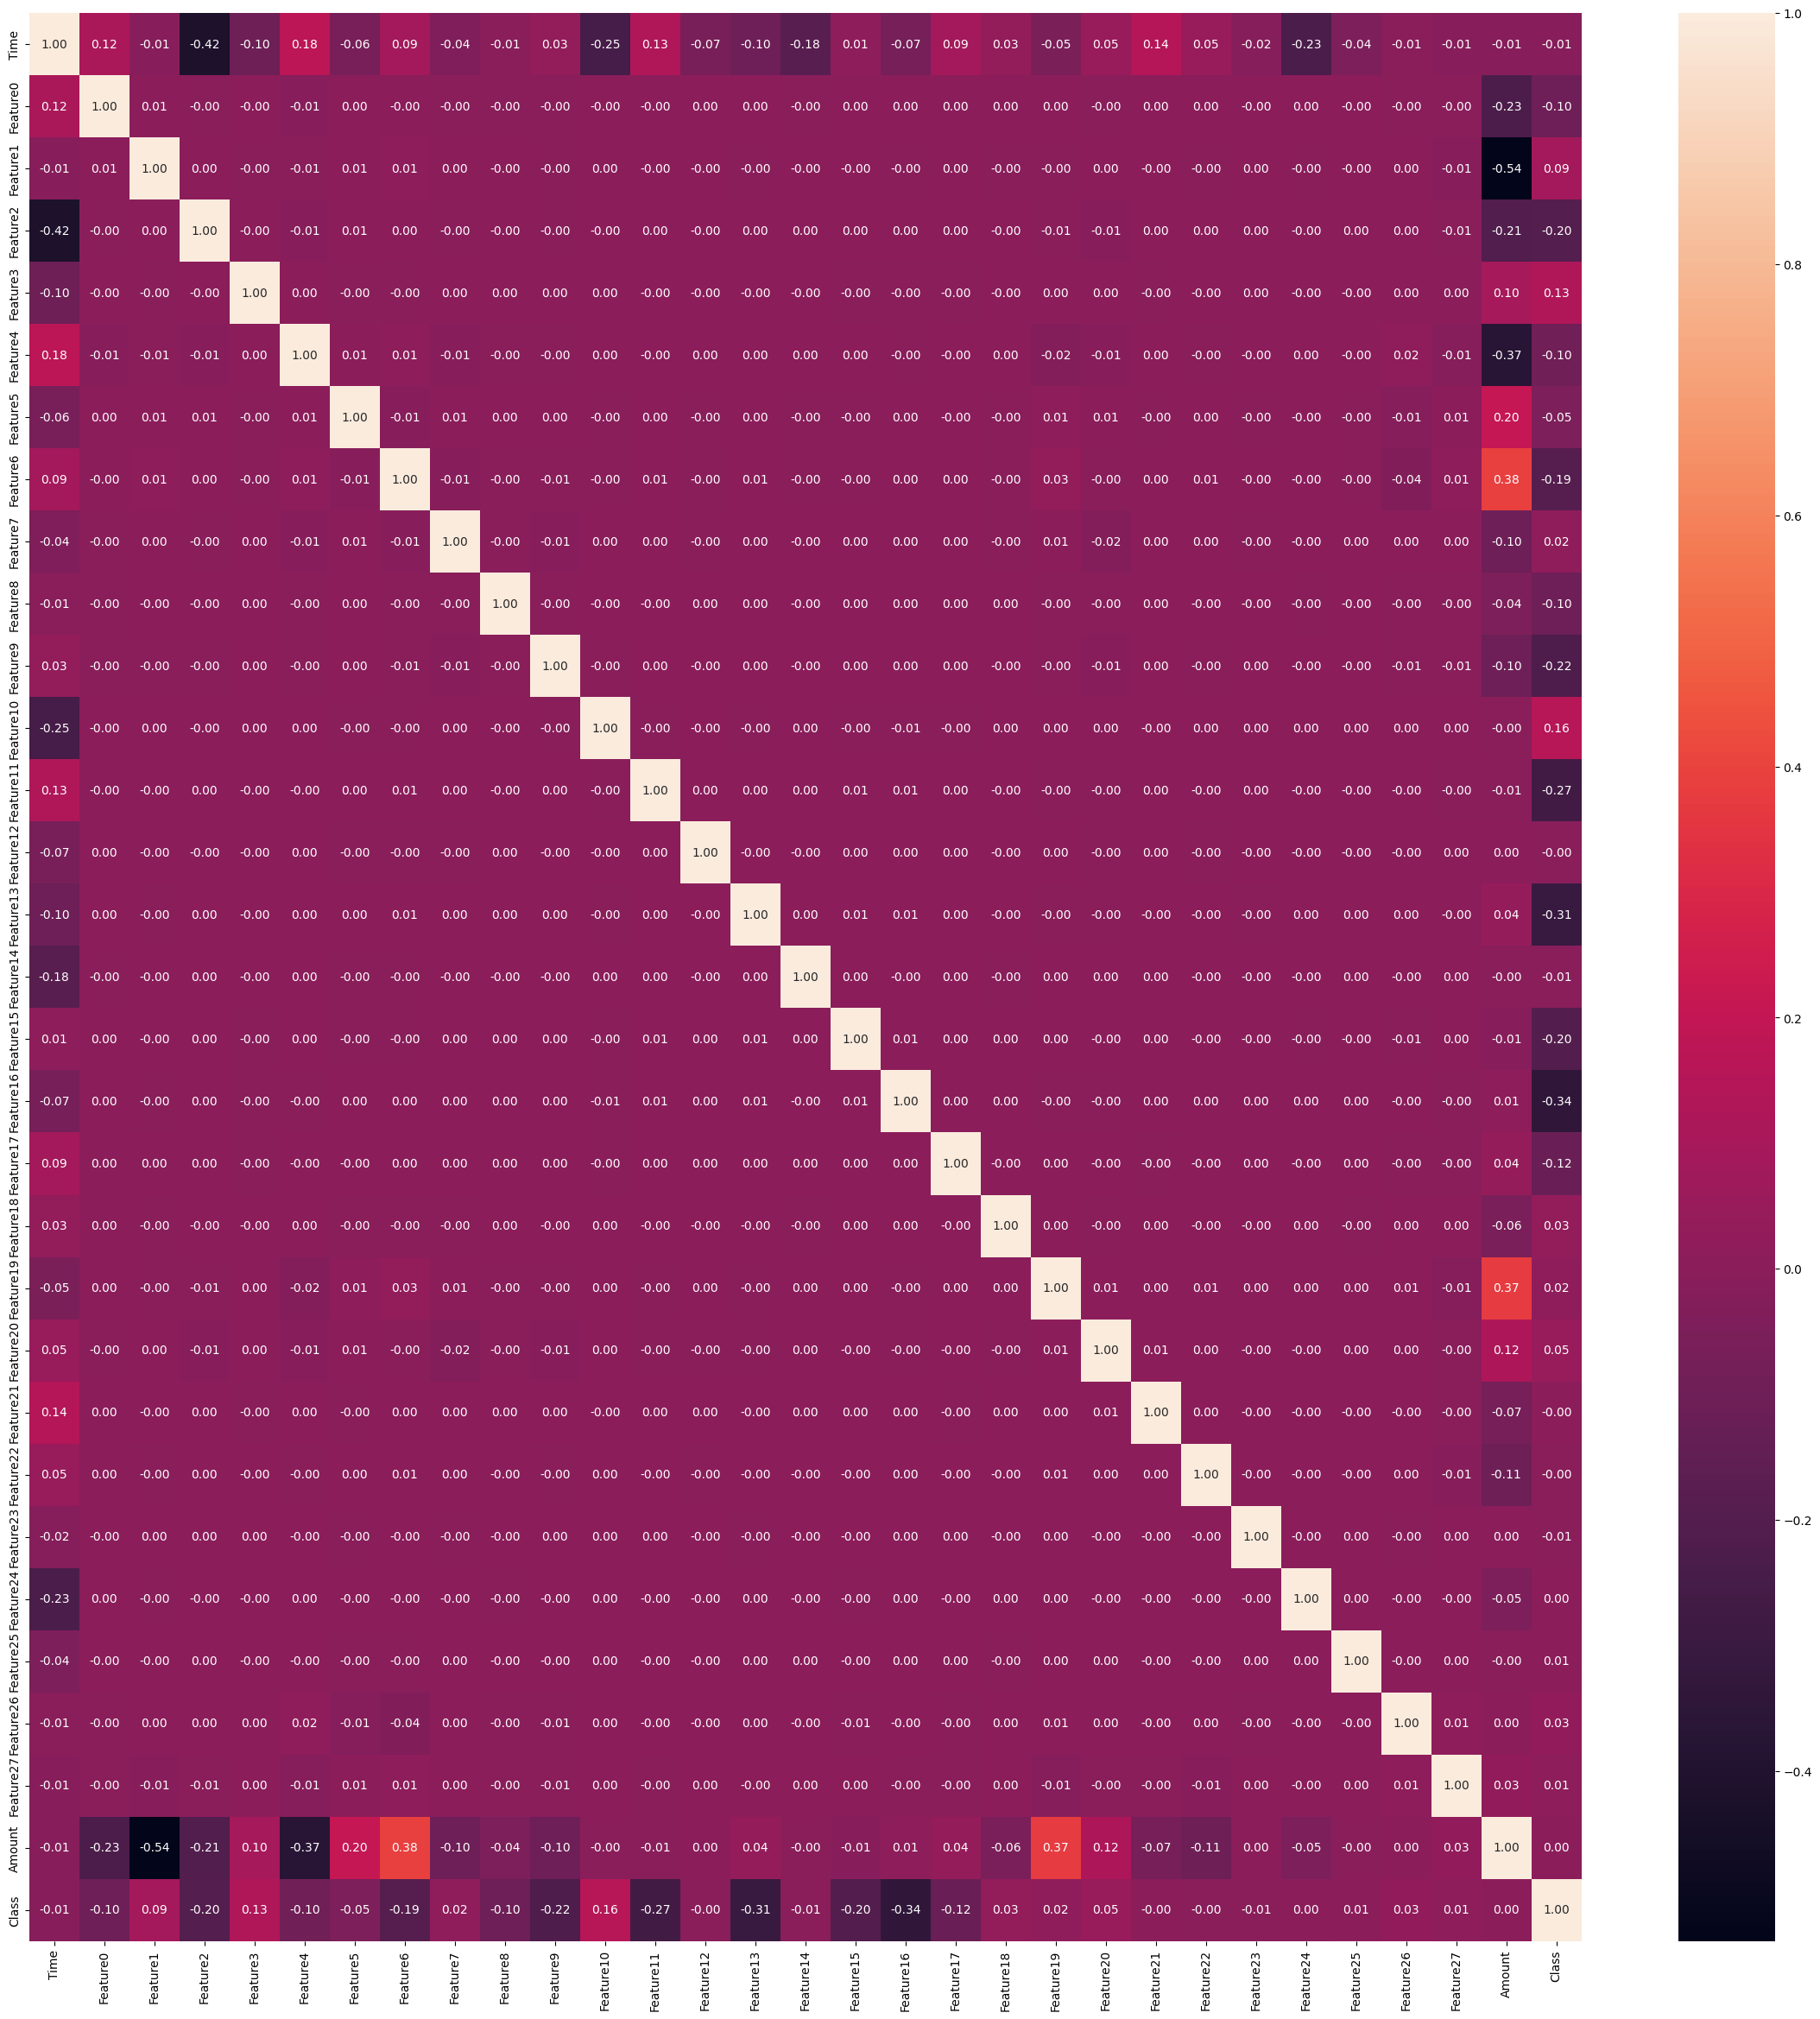

In [4]:
import seaborn as sns
# find out about correlation and if we can eliminate some columns if they have high correlataion
plt.figure(figsize=(29,29))
sns.heatmap(data.corr(), annot=True, fmt='.2f')

In [5]:
count_classes=data['Class'].value_counts()
print(count_classes)

Class
0    227451
1       394
Name: count, dtype: int64


In [6]:
import numpy as np
import pandas as pd
from sklearn import model_selection, metrics
from sklearn.ensemble import HistGradientBoostingClassifier

X = data.drop("Class", axis=1)
y = data["Class"]
X_data = X.values
y_data = y.values
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)
gbc=HistGradientBoostingClassifier(learning_rate=0.01, 
        max_iter=2000, max_leaf_nodes=6, validation_fraction=0.2, 
        n_iter_no_change=15, random_state=42).fit(X_train,y_train)

In [7]:
hardpredtst=gbc.predict(X_test)
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= metrics.confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Legit)', 'True 1(Fraud)'], 
            columns=['Pred 0(Approve as Legit)', 
                            'Pred 1(Deny as Fraud)'])
conf_matrix(y_test,hardpredtst)

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 45492 (TNR = 99.99%),FP = 3 (FPR = 0.01%)
True 1(Fraud),FN = 18 (FNR = 24.32%),TP = 56 (TPR = 75.68%)


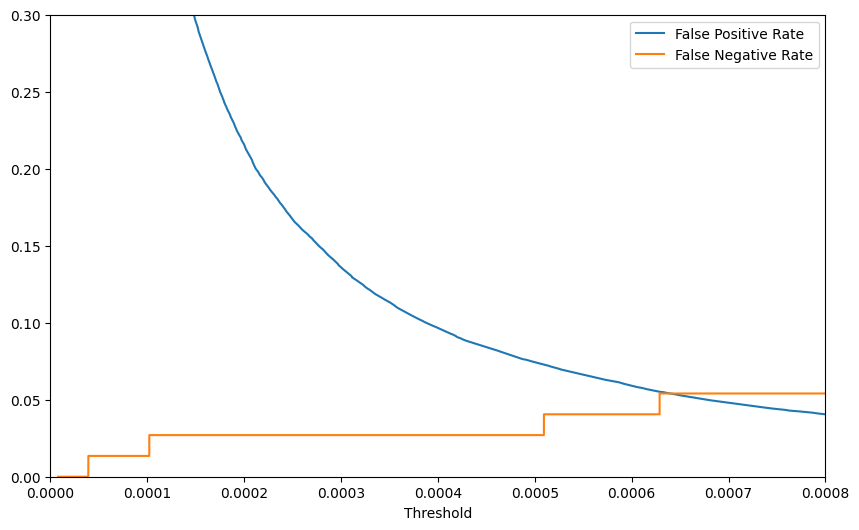

In [8]:
predtst=gbc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predtst)
dfplot=pd.DataFrame({'Threshold':thresholds, 
        'False Positive Rate':fpr, 
        'False Negative Rate': 1.-tpr})
ax=dfplot.plot(x='Threshold', y=['False Positive Rate',
        'False Negative Rate'], figsize=(10,6))
ax.set_xbound(0,0.0008); ax.set_ybound(0,0.3) #zoom in

In [15]:
hardpredtst_tuned_thresh = np.where(predtst >= 0.00045, 1, 0)
conf_matrix(y_test, hardpredtst_tuned_thresh)
# https://towardsdatascience.com/how-to-deal-with-imbalanced-classification-without-re-balancing-the-data-8a3c02353fe3

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 41101 (TNR = 90.34%),FP = 4394 (FPR = 9.66%)
True 1(Fraud),FN = 2 (FNR = 2.70%),TP = 72 (TPR = 97.30%)


In [12]:
X = data.drop("Class", axis=1)
y = data["Class"]
X_data = X.values
y_data = y.values


# split training data
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
# define algorithms for n-fold-cross validation
algorithms = [
    (
        "Logistic Regression",
        LogisticRegression(),
        {
            "penalty": ["l2"],
            "C": [0.001, 0.01, 0.1, 1, 10, 100],
            "class_weight": ["balanced", None, {0: 0.3, 1: 0.7}, {0: 0.1, 1: 0.9}],
        },
    ),
    (
        "Decision Tree",
        DecisionTreeClassifier(),
        {
            "criterion": ["gini", "entropy"],
            "max_depth": [5, 10, 15],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "class_weight": ["balanced", None, {0: 0.3, 1: 0.7}, {0: 0.1, 1: 0.9}],
        },
    ),
    (
        "Random Forest",
        RandomForestClassifier(),
        {
            "n_estimators": [100, 200, 500],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5, 10],
            "class_weight": ["balanced", None, {0: 0.1, 1: 0.9}],
        },
    ),
    (
        "Neural Network",
        MLPClassifier(learning_rate_init=0.001),
        {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "alpha": [0.0001, 0.001, 0.01],
        },
    ),
    (
        "SVM",
        SVC(),
        {
            "class_weight": [{0: 0.1, 1: 0.9}],
        },
    ),
]

In [13]:
# Print data instances where class is '1'
class_1_data = data[data['Class'] == 1]
class_1_data_pretty = class_1_data.to_string(index=False)

print(class_1_data_pretty)

print(data)

    Time   Feature0  Feature1   Feature2  Feature3   Feature4  Feature5   Feature6   Feature7   Feature8   Feature9  Feature10  Feature11  Feature12  Feature13  Feature14  Feature15  Feature16  Feature17  Feature18  Feature19  Feature20  Feature21  Feature22  Feature23  Feature24  Feature25  Feature26  Feature27  Amount  Class
110552.0  -2.450367  2.107729  -5.140663  1.411304  -1.690780 -0.736427  -3.657946   1.944906  -0.788388  -5.624677   3.519642  -7.221590   1.201728  -3.811428  -1.701428  -3.571408  -7.311407  -1.754355   0.795449  -0.130438   0.800538   0.364617   0.233608  -0.282078  -0.320311   0.492920   0.359976  -0.115471   80.22      1
  7672.0   0.702710  2.426433  -5.234513  4.416661  -2.170806 -2.667554  -3.878088   0.911337  -0.166199  -5.009249   4.675729  -8.167188   0.638559  -6.763334   1.296860  -3.811758  -3.754128  -1.049177   1.554197   0.422743   0.551180  -0.009802   0.721698   0.473246  -1.959304   0.319476   0.600485   0.129305    1.00      1
165981.0  -5.

In [16]:
def print_conf_matr(cm):
    fig, ax = plt.subplots(figsize=(8, 6))

    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    cbar = ax.figure.colorbar(im, ax=ax)

    classes = ['0', '1']  # Assuming class 0 and class 1
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    thresh = cm.max() / 2.0  # Threshold for text color
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

    plt.show()

In [17]:
def plot_specificity_sensitivity(model_names, cms):
    specificities = []
    sensitivities = []

    for cm in cms:
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        specificities.append(specificity)
        sensitivities.append(sensitivity)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(model_names, specificities, label='Specificity')
    ax.bar(model_names, sensitivities, label='Sensitivity')

    ax.set_title('Model Comparison - Specificity and Sensitivity')
    ax.set_xlabel('Model')
    ax.set_ylabel('Score')

    ax.legend()

    plt.xticks(rotation=45)

    plt.show()

def plot_scores(model_names, scores, name):
    min_score = min(scores)
    y_min = min_score - 0.01
    y_max = 1.0
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(model_names, scores)

    ax.set_ylim([y_min, y_max])

    ax.set_title('Model Comparison - ' + name)
    ax.set_xlabel('Model')
    ax.set_ylabel(name)

    plt.xticks(rotation=45)

    plt.show()

In [21]:
import matplotlib.pyplot as plt

def train_model(name, model, param_grid):
    print(f"Estimating hyperparameters for {name}, using param grid {param_grid} ...")

    # Estimate hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring="roc_auc", cv=n_fold, verbose=10)
    grid_search.fit(X_scaled, y_train)

    # Get the grid search results
    results = grid_search.cv_results_
    print(results)

    best_parameters = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"{name}")
    print(f"Best params: {best_parameters}, Best score: {best_score}")

    model.set_params(**best_parameters)

    print("Fitting models with best parameters...")
    model.fit(X_scaled, y_train)

    print(f'Fitted Model Parameters: {model.get_params()}\n')

    y_pred = model.predict(X_test)
    score = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"ROC AUC on testing data: {score:.4f}\n")
    print(f"Accuracy on testing data: {accuracy:.4f}\n")

    cm = confusion_matrix(y_test, y_pred)
    print_conf_matr(cm)
    return accuracy, score, cm


In [19]:
# Perform n-fold cross validation for each model to find hyperparameters

n_fold = 5

model_scores = []

log_reg = algorithms[0]
des_tree = algorithms[1]
rand_for = algorithms[2]
mlp = algorithms[3]
svm = algorithms[4]

Estimating hyperparameters for SVM, using param grid {'class_weight': [{0: 0.1, 1: 0.9}]} ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START class_weight={0: 0.1, 1: 0.9}...............................
[CV 1/5; 1/1] END class_weight={0: 0.1, 1: 0.9};, score=0.927 total time=  32.5s
[CV 2/5; 1/1] START class_weight={0: 0.1, 1: 0.9}...............................
[CV 2/5; 1/1] END class_weight={0: 0.1, 1: 0.9};, score=0.977 total time=  34.6s
[CV 3/5; 1/1] START class_weight={0: 0.1, 1: 0.9}...............................
[CV 3/5; 1/1] END class_weight={0: 0.1, 1: 0.9};, score=0.923 total time=  29.7s
[CV 4/5; 1/1] START class_weight={0: 0.1, 1: 0.9}...............................
[CV 4/5; 1/1] END class_weight={0: 0.1, 1: 0.9};, score=0.942 total time=  30.5s
[CV 5/5; 1/1] START class_weight={0: 0.1, 1: 0.9}...............................
[CV 5/5; 1/1] END class_weight={0: 0.1, 1: 0.9};, score=0.918 total time=  39.1s
SVM
Best params: {'class_weight': {0:

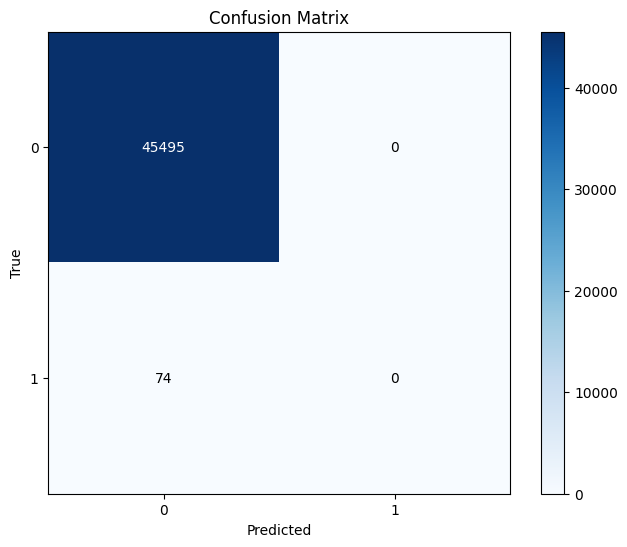

In [22]:
# Train logistic regression
s_n, s_m, s_p_g = svm
s_acc, s_roc, s_cm = train_model(s_n, s_m, s_p_g)

In [ ]:
model_scores.append((s_n, s_acc, s_roc, s_cm))

Estimating hyperparameters for Logistic Regression, using param grid {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': ['balanced', None, {0: 0.3, 1: 0.7}, {0: 0.1, 1: 0.9}]} ...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START C=0.001, class_weight=balanced, penalty=l2.................
[CV 1/5; 1/24] END C=0.001, class_weight=balanced, penalty=l2;, score=0.973 total time=   0.5s
[CV 2/5; 1/24] START C=0.001, class_weight=balanced, penalty=l2.................
[CV 2/5; 1/24] END C=0.001, class_weight=balanced, penalty=l2;, score=0.990 total time=   0.4s
[CV 3/5; 1/24] START C=0.001, class_weight=balanced, penalty=l2.................
[CV 3/5; 1/24] END C=0.001, class_weight=balanced, penalty=l2;, score=0.953 total time=   0.5s
[CV 4/5; 1/24] START C=0.001, class_weight=balanced, penalty=l2.................
[CV 4/5; 1/24] END C=0.001, class_weight=balanced, penalty=l2;, score=0.958 total time=   0.4s
[CV 5/5; 1/24] START C=0.001, cl

ValueError: cannot reshape array of size 24 into shape (1,)

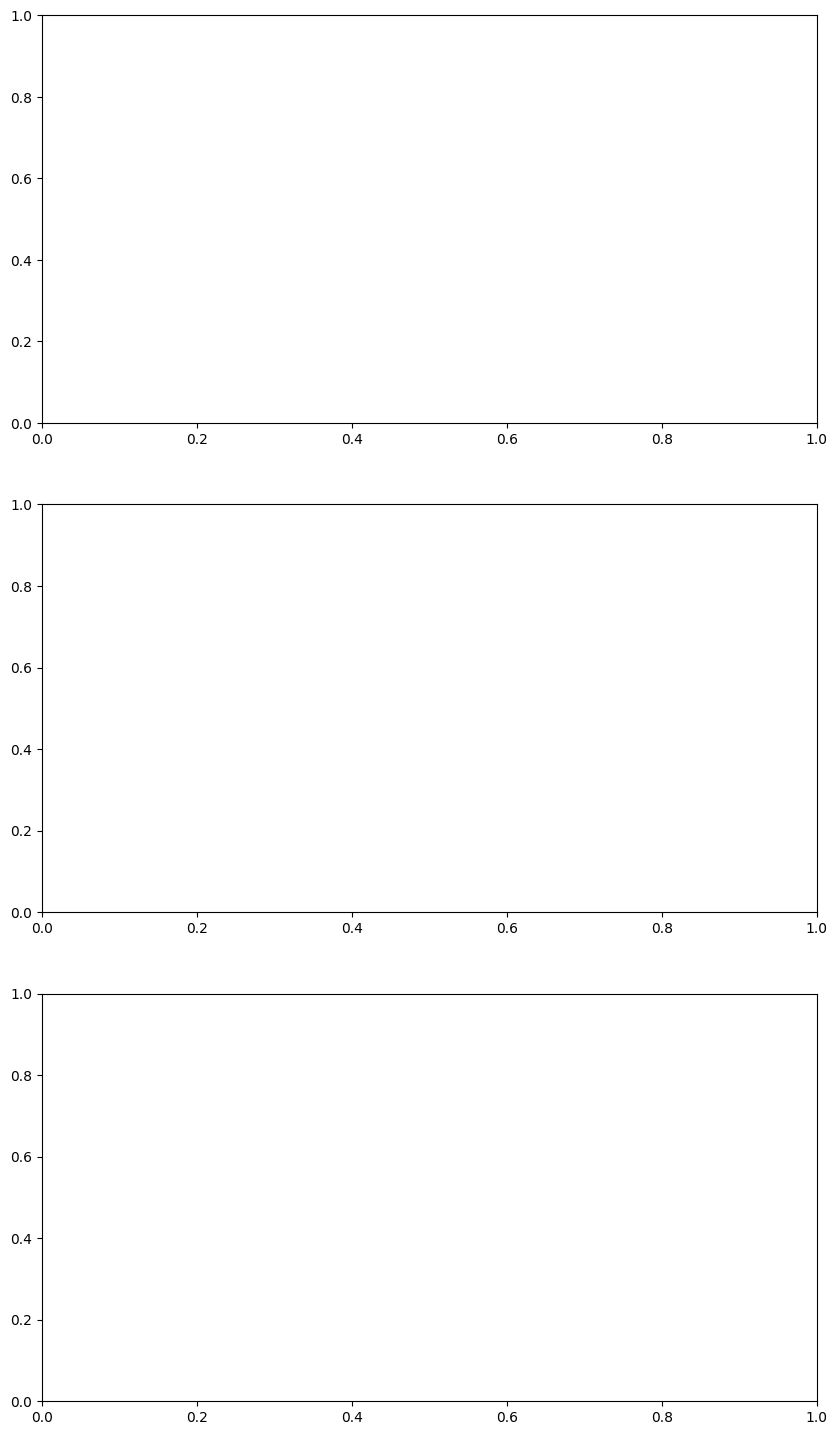

In [90]:
# Train logistic regression
l_n, l_m, l_p_g = log_reg
log_reg_acc, log_reg_roc, log_reg_cm = train_model(l_n, l_m, l_p_g)

In [76]:
model_scores.append((l_n, log_reg_acc, log_reg_roc, log_reg_cm))

Estimating hyperparameters for Decision Tree, using param grid {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': ['balanced', None, {0: 0.3, 1: 0.7}, {0: 0.1, 1: 0.9}]} ...
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END class_weight=balanced, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   3.4s
[CV] END class_weight=balanced, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   3.3s
[CV] END class_weight=balanced, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   2.9s
[CV] END class_weight=balanced, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   3.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   3.3s
[CV] END class_weight=balanced, criterion=gini

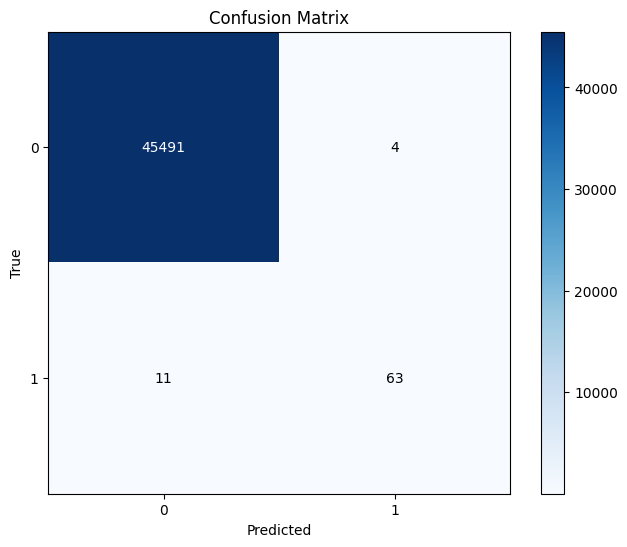

In [49]:
# Train desicion tree
d_n, d_m, d_p_g = des_tree
des_tree_acc, des_tree_roc, des_tree_cm = train_model(d_n, d_m, d_p_g)
# {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

In [77]:
model_scores.append((d_n, des_tree_acc, des_tree_roc, des_tree_cm))

Estimating hyperparameters for Random Forest, using param grid {'n_estimators': [100, 200, 500], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10], 'class_weight': ['balanced', None, {0: 0.1, 1: 0.9}]} ...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=  40.4s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=  36.3s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=  37.8s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=  38.4s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=  39.4s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; total time= 1.3min
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200;

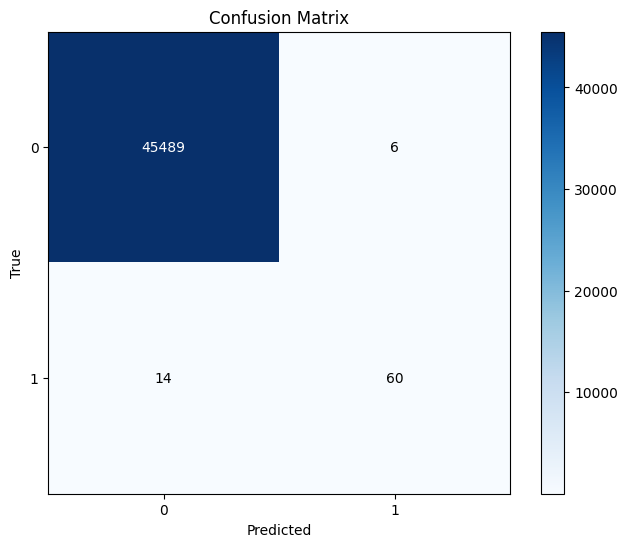

In [74]:
# Train random forest
r_n, r_m, r_p_g = rand_for
rand_for_acc, rand_for_roc, rand_for_cm = train_model(r_n, r_m, r_p_g)
# {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
# {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

In [78]:
model_scores.append((r_n, rand_for_acc, rand_for_roc, rand_for_cm))

Estimating hyperparameters for Neural Network, using param grid {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001, 0.01]} ...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,); total time=  16.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,); total time=  29.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,); total time=  17.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,); total time=  19.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,); total time=  21.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,); total time=  43.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,); total time=  25.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,); total time=  20.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,); total t

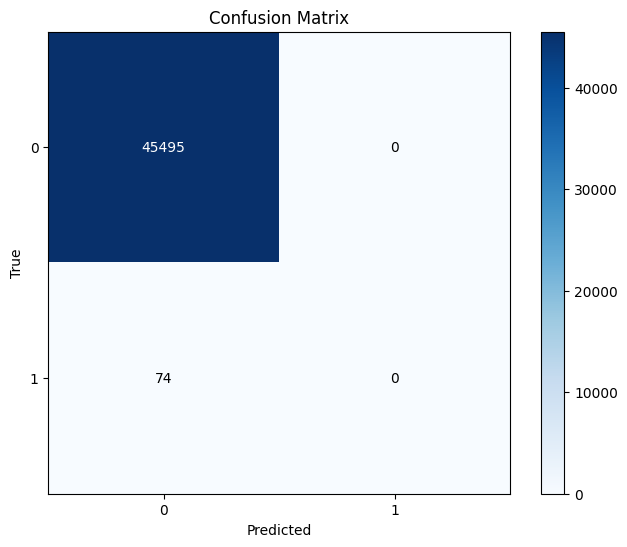

In [63]:
# Train mlp
mlp_n, mlp_m, mlp_p_g = mlp
mlp_acc, mlp_roc, mlp_cm = train_model(mlp_n, mlp_m, mlp_p_g)

In [79]:

model_scores.append((mlp_n, mlp_acc, mlp_roc, mlp_cm))

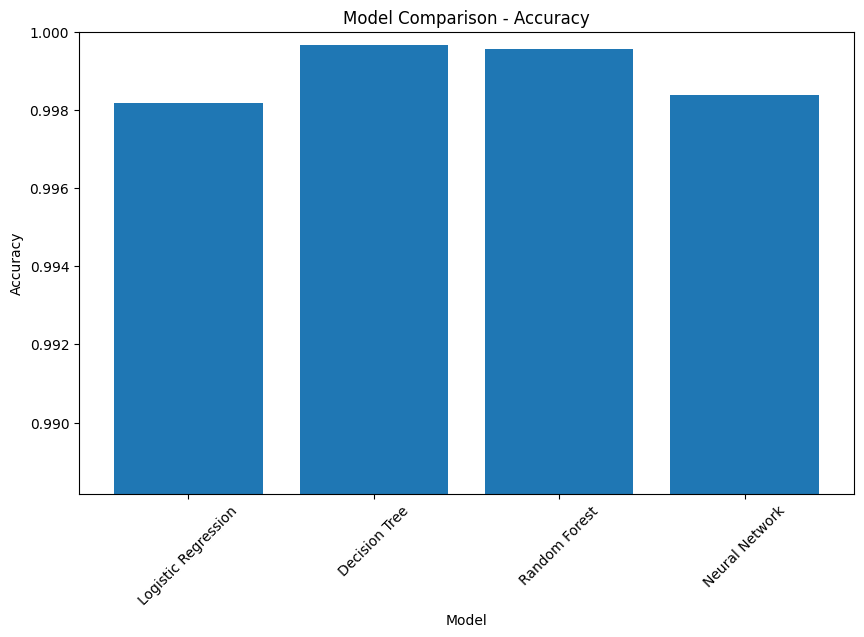

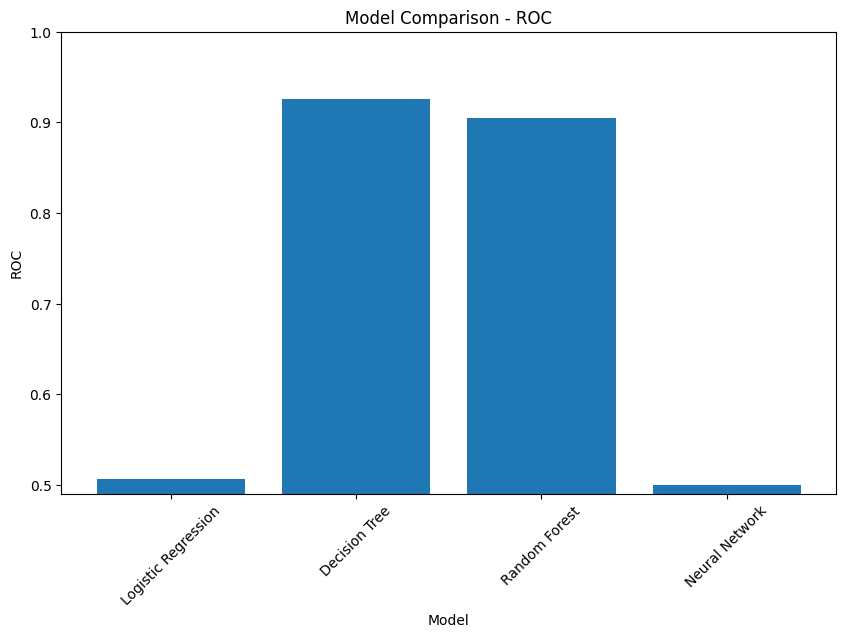

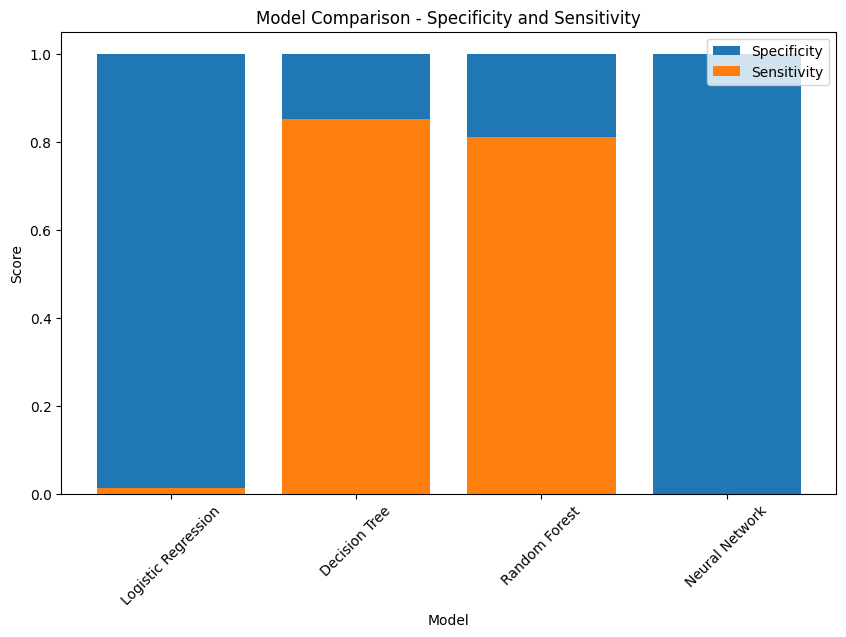

In [80]:
# Lastly, plot every method to see which one is best
model_names = [name for name, _, _, _ in model_scores]
accuracy_scores = [acc for _, acc, _, _ in model_scores]
roc_scores = [roc for _, _, roc, _ in model_scores]

cms = [cm for _, _, _, cm in model_scores]

plot_scores(model_names, accuracy_scores, 'Accuracy')
plot_scores(model_names, roc_scores, 'ROC')

plot_specificity_sensitivity(model_names, cms)

## The Leaderboard Predict function
Replace the comment and `NotImplementedError` in the `leader_board_predict_fn` with code that loads your model parameters and returns the likelyhood of fraud for each transaction (i.e. row) in the values dataframe. Note that the returned array should contain a single decision function value for each transaction, indicating whether the transaction is fraudulent (i.e. it belongs to target class $1$). The higher the decision function value, the more likely that the transaction is fraud.
You can import the packages you require.

Estimating hyperparameters for Decision Tree, using param grid {'max_depth': [5, 6, 7], 'max_features': ['sqrt', 'log2', None], 'criterion': ['gini', 'entropy', 'log_loss']} ...
Decision Tree
Best params: {'criterion': 'gini', 'max_depth': 5, 'max_features': None}, Accuracy: 0.9994184638252415
Fitting models with best parameters...
Fitted Model Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

Accuracy on testing data: 0.9995



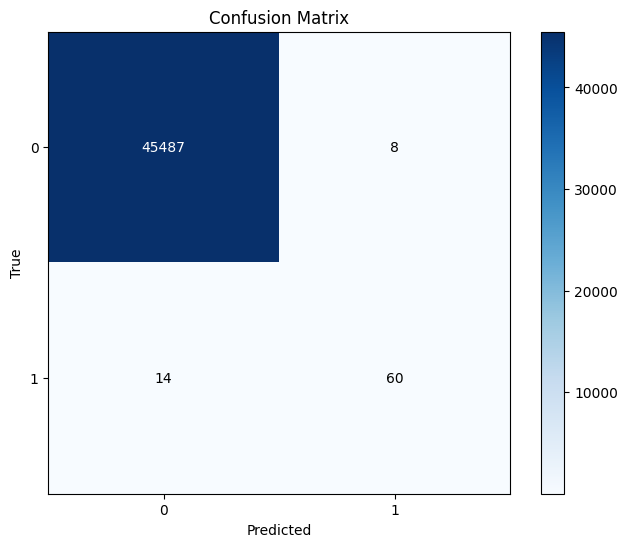

In [11]:
# train tree
tree_algorithm = ('Decision Tree', DecisionTreeClassifier(), {
    'max_depth': [5,6,7], 
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    })

tree_n, tree_m, tree_p_g = tree_algorithm
tree_acc, tree_cm = train_model(tree_n, tree_m, tree_p_g)

In [13]:
def leader_board_predict_fn(values):
    
    decision_function_values = r_m.predict(values)
    
    return decision_function_values

## Testing your Implementation
Your model should return the probability or decision function value that indicates the likelyhood of fraud for each input transaction. To verify that this is the case, we run your model on a subset of the transactions dataset it was trained on. There is a hidden cell that performs the actual test on the unseen test set and computes your score for the leaderboard using the [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) score.

In [15]:
def get_score():
    """
    Function to compute scores for train and test datasets.
    """

    import pandas as pd
    import numpy as np
    import os
    from sklearn.metrics import roc_auc_score
    import pathlib

    try:
        path = "./data/" if os.path.exists("./data") else "."
        test_data = pd.read_csv(os.path.join(path, "transactions.csv"))
        X_test = test_data.drop(columns = "Class")
        y_test = test_data["Class"]
        decision_function_values = leader_board_predict_fn(X_test)
        assert decision_function_values.shape == (X_test.shape[0],)
        dataset_score = roc_auc_score(y_test, decision_function_values)
        assert dataset_score >= 0.0 and dataset_score <= 1.0
    except Exception:
        dataset_score = float("nan")
    print(f"Train Dataset Score: {dataset_score}")

    import os
    import pwd
    import time
    import datetime
    import pandas as pd
    user_id = pwd.getpwuid( os.getuid() ).pw_name
    curtime = time.time()
    dt_now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

    try:
        HIDDEN_DATASET_PATH = os.path.expanduser("/data/mlproject22-test-data")
        test_data = pd.read_csv(os.path.join(HIDDEN_DATASET_PATH,"transactions_scoreboard.csv.zip"))
        X_test = test_data.drop(columns=["Class"])
        y_test = test_data["Class"]
        decision_function_values = leader_board_predict_fn(X_test)
        hiddendataset_score = roc_auc_score(y_test, decision_function_values)
        print(f"Test Dataset Score: {hiddendataset_score}")
        score_dict = dict(
            score_hidden=hiddendataset_score,
            score_train=dataset_score,
            unixtime=curtime,
            user=user_id,
            dt=dt_now,
            comment="",
        )
    except Exception as e:
        err = str(e)
        score_dict = dict(
            score_hidden=float("nan"),
            score_train=dataset_score,
            unixtime=curtime,
            user=user_id,
            dt=dt_now,
            comment=err
        )

    #if list(pathlib.Path(os.getcwd()).parents)[0].name == 'source':
    #    print("we are in the source directory... replacing values.")
    #    print(pd.DataFrame([score_dict]))
    #    score_dict["score_hidden"] = -1
    #    score_dict["score_train"] = -1
    #    print("new values:")
    #    print(pd.DataFrame([score_dict]))

    pd.DataFrame([score_dict]).to_csv("transactions.csv", index=False)
    
get_score()

/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Train Dataset Score: 0.8958555518188589


NameError: name 'score_dict' is not defined